In [2]:
import os, math, json, time, random, re, inspect
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from collections import defaultdict

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from PIL import Image

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score, precision_recall_curve, roc_curve
from sklearn.linear_model import LogisticRegression

# ---- Paths (from your message) ----
CSV_PATH   = r"D:\research\Thesis_data\TCGA-LUAD\RNA_Seq2"
IMAGE_ROOT = r"D:\research\Thesis_data\TCGA-LUAD\TCGA-LUAD png"
OUT_DIR    = Path(r"D:\research\Thesis_data\TCGA-LUAD")

# ---- Core knobs ----
NUM_FOLDS        = 5
NUM_REPEATS      = 1
SEEDS            = [42]
USE_PCA          = True
PCA_DIM          = 128
DROPOUT          = 0.4
WEIGHT_DECAY     = 1e-4

# Image bags
K_SLICES_TRAIN   = 48
K_SLICES_VAL     = 48
VAL_TTA_BAGS     = 4

IMG_SIZE         = 224
BACKBONE         = "resnet50"
PRETRAINED       = True

WARMUP_EPOCHS    = 5
MAX_EPOCHS       = 50
PATIENCE         = 8
LR_WARMUP        = 1e-3
LR_FINETUNE      = 1e-4

THRESH_POLICY    = "youden"
USE_CALIBRATION  = True

NUM_WORKERS      = 0
BATCH_SIZE       = 1
GRAD_ACCUM_STEPS = 1

CUDNN_DETERMINISTIC = True

# normalize SEEDS
if isinstance(SEEDS, (int, np.integer)): SEEDS=[int(SEEDS)]
elif isinstance(SEEDS, tuple): SEEDS=list(SEEDS)
elif not isinstance(SEEDS, list):
    try: SEEDS=list(SEEDS)
    except: SEEDS=[42]
print("SEEDS =", SEEDS)

IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
TCGA_RE  = re.compile(r'(TCGA-[A-Z0-9]{2}-[A-Z0-9]{4})', re.I)

def set_seed(seed: int):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    if CUDNN_DETERMINISTIC:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def worker_init_fn(worker_id):
    base_seed = torch.initial_seed() % 2**32
    np.random.seed(base_seed + worker_id)
    random.seed(base_seed + worker_id)

def norm_id(s: str) -> str:
    return re.sub(r'[^A-Z0-9]', '', str(s).upper())

def index_images_robust(image_root: str) -> Dict[str, List[Path]]:
    root = Path(image_root)
    if not root.exists():
        raise FileNotFoundError(f"IMAGE_ROOT not found: {root}")
    buckets = defaultdict(list)
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            rel = p.relative_to(root); parts = rel.parts
            pid = None
            if len(parts) >= 2:
                top = parts[0]
                m = TCGA_RE.search(top); pid = m.group(1).upper() if m else top.strip()
            if not pid:
                m = TCGA_RE.search(p.stem)
                if m: pid = m.group(1).upper()
            if not pid:
                base = p.stem; pid = base.split("_")[0].split("-slide")[0]
            pid = norm_id(pid)
            if pid: buckets[pid].append(p)
    return {pid: sorted(set(lst)) for pid, lst in buckets.items() if lst}

def compute_pos_weight(y: List[int]) -> torch.Tensor:
    y = np.asarray(y).astype(int); n_pos = (y==1).sum(); n_neg=(y==0).sum()
    val = 1.0 if n_pos==0 else max(1.0, n_neg/max(1,n_pos))
    return torch.tensor([val], dtype=torch.float32)

def choose_threshold(y_true: np.ndarray, probs: np.ndarray, policy: str = "youden"):
    y_true = np.asarray(y_true).astype(int); probs = np.asarray(probs).astype(float)
    if policy == "f1":
        precision, recall, thr = precision_recall_curve(y_true, probs)[:3]
        f1 = (2*precision*recall)/np.clip(precision+recall, 1e-12, None)
        idx = (np.nanargmax(f1[:-1]) if len(f1)>1 else 0)
        t = thr[idx] if len(thr) else 0.5
    else:
        fpr, tpr, thr = roc_curve(y_true, probs); j = tpr - fpr
        idx = np.nanargmax(j); t = thr[idx] if len(thr) else 0.5
    preds = (probs >= t).astype(int)
    metrics = {"ACC": accuracy_score(y_true, preds),
               "F1": f1_score(y_true, preds) if len(np.unique(y_true))>1 else 1.0}
    return float(t), metrics

def load_csv_robust(csv_path: str) -> pd.DataFrame:
    p = Path(csv_path)
    if p.is_dir():
        csv_files = sorted(p.glob("*.csv"))
        if not csv_files:
            raise FileNotFoundError(f"No .csv in {p}")
        for f in csv_files:
            try:
                dfp = pd.read_csv(f, nrows=10)
                if "patient_id" in dfp.columns and "label" in dfp.columns:
                    print(f"[CSV] Using: {f.name}")
                    return pd.read_csv(f)
            except Exception:
                pass
        print(f"[CSV] Using first (schema unknown): {csv_files[0].name}")
        return pd.read_csv(csv_files[0])
    elif p.is_file():
        print(f"[CSV] Using: {p.name}")
        return pd.read_csv(p)
    else:
        raise FileNotFoundError(f"CSV_PATH does not exist: {p}")

def preflight(CSV_PATH, IMAGE_ROOT):
    df = load_csv_robust(CSV_PATH)
    assert "patient_id" in df and "label" in df, "CSV must include 'patient_id' and 'label'"
    rna_cols = [c for c in df.columns if c not in ("patient_id","label")]
    assert len(rna_cols)>0, "No RNA feature columns"
    df['label']=df['label'].astype(int)
    imgs = index_images_robust(IMAGE_ROOT)

    # normalize IDs
    df = df.copy()
    df['patient_id'] = df['patient_id'].astype(str).str.upper().map(norm_id)
    imgs = {norm_id(k):v for k,v in imgs.items()}

    csv_ids, img_ids = set(df['patient_id']), set(imgs.keys())
    inter = csv_ids & img_ids
    print(f"[Preflight] CSV patients: {len(csv_ids)} | Image patients: {len(img_ids)} | Intersection: {len(inter)}")
    miss_csv = sorted(list(csv_ids - img_ids))
    miss_img = sorted(list(img_ids - csv_ids))
    if miss_csv: print('[Preflight] CSV-only (no images) sample:', miss_csv[:10])
    if miss_img: print('[Preflight] Image-only (no CSV) sample:', miss_img[:10])

    df_match = df[df['patient_id'].isin(inter)].reset_index(drop=True)
    print('[Preflight] Label counts after match:\n', df_match['label'].value_counts().sort_index())
    return df_match, rna_cols, imgs

df_match, rna_cols, patient_images = preflight(CSV_PATH, IMAGE_ROOT)

class RNAPreprocessor:
    def __init__(self, use_pca=True, pca_dim=128, min_keep_dim=1, verbose=True):
        self.use_pca = use_pca
        self.pca_dim = pca_dim
        self.min_keep_dim = min_keep_dim
        self.verbose = verbose
        self.scaler = StandardScaler()
        self.pca = None
        self.actual_dim_ = None
    def fit(self, X):
        Xs = self.scaler.fit_transform(X)
        if not self.use_pca:
            self.actual_dim_ = Xs.shape[1]; return
        max_comp = int(min(Xs.shape[0], Xs.shape[1]))
        n = int(min(self.pca_dim, max_comp))
        if n < self.min_keep_dim:
            if self.verbose: print(f"[RNA] PCA disabled for this fold (n_components would be {n} < {self.min_keep_dim}).")
            self.use_pca = False; self.pca=None; self.actual_dim_=Xs.shape[1]; return
        self.pca = PCA(n_components=n); self.pca.fit(Xs); self.actual_dim_=n
        if self.verbose: print(f"[RNA] PCA fitted with n_components={n} (train samples={Xs.shape[0]}, features={Xs.shape[1]}).")
    def transform(self, X):
        Xs = self.scaler.transform(X)
        if self.use_pca and self.pca is not None: return self.pca.transform(Xs)
        return Xs
    def state_dict(self):
        state = {
            "use_pca": self.use_pca,
            "pca_dim": self.pca_dim,
            "min_keep_dim": self.min_keep_dim,
            "actual_dim": self.actual_dim_,
            "scaler_mean": self.scaler.mean_.tolist(),
            "scaler_scale": self.scaler.scale_.tolist(),
        }
        if self.use_pca and self.pca is not None:
            state.update({
                "pca_components": self.pca.components_.tolist(),
                "pca_mean": self.pca.mean_.tolist(),
                "pca_explained_variance": self.pca.explained_variance_.tolist()
            })
        return state
    def load_state_dict(self, state: dict):
        self.use_pca = state.get("use_pca", True)
        self.pca_dim = int(state.get("pca_dim", 128))
        self.min_keep_dim = int(state.get("min_keep_dim", 1))
        self.actual_dim_ = state.get("actual_dim", None)
        self.scaler = StandardScaler()
        self.scaler.mean_ = np.array(state["scaler_mean"], dtype=float)
        self.scaler.scale_ = np.array(state["scaler_scale"], dtype=float)
        self.scaler.n_features_in_ = self.scaler.mean_.shape[0]
        if self.use_pca and "pca_components" in state:
            self.pca = PCA(n_components=len(state["pca_components"]))
            self.pca.components_ = np.array(state["pca_components"], dtype=float)
            self.pca.mean_ = np.array(state["pca_mean"], dtype=float)
            self.pca.explained_variance_ = np.array(state["pca_explained_variance"], dtype=float)
            self.pca.n_features_in_ = self.pca.components_.shape[1]
        else:
            self.pca = None

class BagDataset(Dataset):
    def __init__(self, patients, labels, patient_to_paths, rna_table, rna_cols,
                 k_slices, train, fixed_indices=None, img_size=224):
        self.patients = list(patients)
        self.labels = labels
        self.patient_to_paths = patient_to_paths
        self.rna_table = rna_table.set_index("patient_id")
        self.rna_cols = rna_cols
        self.k = k_slices; self.train = train
        self.fixed_indices = fixed_indices or {}
        if train:
            self.transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ColorJitter(0.1,0.1,0.1,0.05),
                transforms.ToTensor()
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor()
            ])
    def __len__(self): return len(self.patients)
    def _pick_indices(self, pid, n):
        paths = self.patient_to_paths[pid]
        if self.train:
            if len(paths)<=n:
                idxs=list(range(len(paths)))
                while len(idxs)<n: idxs+=idxs
                return idxs[:n]
            else: return random.sample(range(len(paths)), n)
        else:
            if pid in self.fixed_indices:
                idxs = self.fixed_indices[pid]
                if len(idxs)>=n: return idxs[:n]
                rep=(n+len(idxs)-1)//len(idxs); return (idxs*rep)[:n]
            L=len(paths)
            if L<=n:
                idxs=list(range(L))
                while len(idxs)<n: idxs+=idxs
                return idxs[:n]
            step=L/n; return [int(i*step) for i in range(n)]
    def __getitem__(self, idx):
        pid = self.patients[idx]
        paths = self.patient_to_paths[pid]
        idxs = self._pick_indices(pid, self.k)
        imgs=[]
        for i in idxs:
            im = Image.open(paths[i]).convert("RGB")
            imgs.append(self.transform(im))
        bag = torch.stack(imgs, dim=0)  # [K,C,H,W]
        label = self.labels[pid]
        rna = torch.tensor(self.rna_table.loc[pid, self.rna_cols].values, dtype=torch.float32)  # [D]
        return {'bag': bag, 'rna': rna, 'label': torch.tensor(label, dtype=torch.float32), 'pid': pid}

def make_backbone(name="resnet50", pretrained=True):
    import torchvision.models as M
    weights = None
    if pretrained:
        try:
            if name == "resnet50":
                from torchvision.models import ResNet50_Weights
                weights = ResNet50_Weights.DEFAULT
            else:
                weights = "IMAGENET1K_V1"
        except Exception:
            weights = None
    ctor = getattr(M, name)
    try: m = ctor(weights=weights)
    except TypeError: m = ctor(pretrained=pretrained)
    modules = list(m.children())[:-1]
    feat_dim = m.fc.in_features
    body = nn.Sequential(*modules)
    last_block = m.layer4
    return body, feat_dim, last_block

class AttnMIL(nn.Module):
    def __init__(self, in_dim, hid=256):
        super().__init__()
        self.att_a = nn.Sequential(nn.Linear(in_dim, hid), nn.Tanh())
        self.att_b = nn.Sequential(nn.Linear(in_dim, hid), nn.Sigmoid())
        self.att_c = nn.Linear(hid, 1)
    def _att(self, X):  # X: (..., D)
        A = self.att_a(X) * self.att_b(X)  # (..., H)
        A = self.att_c(A).squeeze(-1)      # (...,)
        return A
    def forward(self, feats):
        if feats.dim() == 2:
            A = self._att(feats)           # [K]
            w = torch.softmax(A, dim=0)    # over K
            bag_feat = torch.sum(w.unsqueeze(-1)*feats, dim=0)  # [D]
            return bag_feat, w
        elif feats.dim() == 3:
            B, K, D = feats.shape
            A = self._att(feats)           # [B,K]
            w = torch.softmax(A, dim=1)    # over K
            bag_feat = torch.sum(w.unsqueeze(-1)*feats, dim=1)  # [B,D]
            return bag_feat, w
        else:
            raise ValueError(f"Unsupported feats dim: {feats.shape}")

class FusionModel(nn.Module):
    def __init__(self, rna_dim, backbone_name, pretrained=True, dropout=0.4):
        super().__init__()
        self.rna_in_dim = int(rna_dim)
        self.backbone, img_dim, self.last_block = make_backbone(backbone_name, pretrained=pretrained)
        self.img_proj = nn.Linear(img_dim, 512)
        self.mil_pool = AttnMIL(512, hid=256)
        self.rna_mlp = nn.Sequential(
            nn.Linear(self.rna_in_dim, 256), nn.ReLU(inplace=True), nn.Dropout(dropout),
            nn.Linear(256, 128), nn.ReLU(inplace=True), nn.Dropout(dropout)
        )
        self.fusion = nn.Sequential(
            nn.Linear(128+512, 256), nn.ReLU(inplace=True), nn.Dropout(dropout),
            nn.Linear(256, 1)
        )
    def forward_backbone_feats(self, bag):
        # bag: [K,C,H,W] or [B,K,C,H,W]
        if bag.dim() == 4:
            K, C, H, W = bag.shape
            x = self.backbone(bag)          # [K, 2048, 1, 1]
            x = x.flatten(1)                # [K, 2048]
            x = self.img_proj(x)            # [K, 512]
            return x
        elif bag.dim() == 5:
            B, K, C, H, W = bag.shape
            x = bag.view(B*K, C, H, W)      # [B*K, C, H, W]
            x = self.backbone(x)            # [B*K, 2048, 1, 1]
            x = x.flatten(1)                # [B*K, 2048]
            x = self.img_proj(x)            # [B*K, 512]
            x = x.view(B, K, -1)            # [B, K, 512]
            return x
        else:
            raise ValueError(f"Unexpected bag shape: {bag.shape}")
    def _normalize_rna_batch(self, rna, B):
        # Target: [B, self.rna_in_dim]
        if rna.dim() == 1:            # [D]
            rna = rna.unsqueeze(0)    # [1,D]
        if rna.dim() == 2:            # [B,D] or [1,D]
            if rna.size(0) != B:
                if rna.size(0) == 1:
                    rna = rna.expand(B, -1).contiguous()
                else:
                    rna = rna[:B]
            # adjust feature dim if needed
            if rna.size(1) != self.rna_in_dim:
                if rna.size(1) > self.rna_in_dim:
                    rna = rna[:, :self.rna_in_dim]
                else:
                    pad = self.rna_in_dim - rna.size(1)
                    rna = F.pad(rna, (0, pad))
            return rna
        if rna.dim() == 3:            # [B,M,D] variants
            # Prefer squeezing singleton middle dim
            if rna.size(0) == 1 and rna.size(1) == B:
                rna = rna.squeeze(0)           # [B,D]
            elif rna.size(0) == B and rna.size(1) == 1:
                rna = rna.squeeze(1)           # [B,D]
            else:
                # If last dim == expected, average over middle
                if rna.size(-1) == self.rna_in_dim:
                    if rna.size(0) == B:
                        rna = rna.mean(dim=1)  # [B,D]
                    else:
                        rna = rna.mean(dim=0)  # [M,D] -> hope M==B after slice/expand below
                else:
                    # Flatten then reduce/trim to expected
                    rna = rna.reshape(B, -1)
            # ensure [B,D]
            if rna.dim() == 2 and rna.size(0) != B:
                if rna.size(0) == 1:
                    rna = rna.expand(B, -1).contiguous()
                else:
                    rna = rna[:B]
            if rna.size(1) != self.rna_in_dim:
                if rna.size(1) % self.rna_in_dim == 0 and rna.size(1) > self.rna_in_dim:
                    chunks = rna.view(B, -1, self.rna_in_dim)
                    rna = chunks.mean(dim=1)
                elif rna.size(1) > self.rna_in_dim:
                    rna = rna[:, :self.rna_in_dim]
                else:
                    pad = self.rna_in_dim - rna.size(1)
                    rna = F.pad(rna, (0, pad))
            return rna
        # Fallback for higher dims
        rna = rna.view(B, -1)
        if rna.size(1) != self.rna_in_dim:
            if rna.size(1) > self.rna_in_dim:
                rna = rna[:, :self.rna_in_dim]
            else:
                pad = self.rna_in_dim - rna.size(1)
                rna = F.pad(rna, (0, pad))
        return rna
    def forward(self, bag, rna):
        feats = self.forward_backbone_feats(bag)  # [K,512] or [B,K,512]
        if feats.dim() == 2:
            bag_feat, att_w = self.mil_pool(feats)  # [512], [K]
            if rna.dim() != 1:
                rna = rna.view(-1)                  # collapse to [D]
            if rna.numel() >= self.rna_in_dim:
                rna = rna[:self.rna_in_dim]
            else:
                rna = F.pad(rna, (0, self.rna_in_dim - rna.numel()))
            rna_feat = self.rna_mlp(rna)            # [128]
            fused = torch.cat([bag_feat, rna_feat], dim=-1)   # [640]
            logit = self.fusion(fused).squeeze(-1)            # []
            return logit, att_w
        else:
            B = feats.shape[0]
            bag_feat, att_w = self.mil_pool(feats)            # [B,512], [B,K]
            rna = self._normalize_rna_batch(rna, B)           # -> [B, self.rna_in_dim]
            rna_feat = self.rna_mlp(rna)                      # [B,128]
            fused = torch.cat([bag_feat, rna_feat], dim=-1)   # [B,640]
            logit = self.fusion(fused).squeeze(-1)            # [B]
            return logit, att_w
    def freeze_backbone(self):
        for p in self.backbone.parameters(): p.requires_grad=False
    def unfreeze_last_block(self):
        for p in self.last_block.parameters(): p.requires_grad=True

def freeze_bn(module):
    for m in module.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()
            m.weight.requires_grad_(False)
            m.bias.requires_grad_(False)

def train_one_epoch(model, loader, optimizer, criterion, device, grad_accum=1):
    model.train(); total=0.0; optimizer.zero_grad(set_to_none=True)
    for step, batch in enumerate(loader):
        bag = batch['bag'].to(device)                 # [B,K,C,H,W]
        rna = batch['rna'].to(device)                 # [B,D] or odd -> normalized in forward()
        y   = batch['label'].to(device)               # [B]
        logit, _ = model(bag, rna)                    # [B] or []
        loss = criterion(logit.view(-1), y.view(-1))
        loss.backward()
        if (step+1)%grad_accum==0:
            optimizer.step(); optimizer.zero_grad(set_to_none=True)
        total += loss.item()
    return total / max(1, len(loader))

@torch.no_grad()
def eval_predict(model, loader, device, tta_bags=1):
    model.eval()
    y_true, logits, pids = [], [], []
    for batch in loader:
        pid = batch['pid']; rna = batch['rna'].to(device)
        lbl = int(batch['label'].cpu().numpy().item())
        agg=[]
        for _ in range(tta_bags):
            bag = batch['bag'].to(device)
            logit, _ = model(bag, rna)
            agg.append(float(logit.view(-1).cpu().numpy()[0]))
        y_true.append(lbl); logits.append(float(np.mean(agg))); pids.append(pid)
    y_true = np.array(y_true); logits = np.array(logits)
    probs = 1/(1+np.exp(-logits))
    return y_true, logits, probs, pids

def metrics_from_probs(y_true, probs, thr=0.5):
    if len(np.unique(y_true))>1:
        auroc = roc_auc_score(y_true, probs); auprc = average_precision_score(y_true, probs)
        preds = (probs>=thr).astype(int); acc=accuracy_score(y_true, preds); f1=f1_score(y_true, preds)
    else:
        auroc=auprc=acc=f1=1.0
    return {'AUROC':auroc,'AUPRC':auprc,'ACC':acc,'F1':f1,'THR':thr}

def _make_plateau_scheduler(optimizer):
    sig = inspect.signature(torch.optim.lr_scheduler.ReduceLROnPlateau)
    has_verbose = 'verbose' in sig.parameters
    if has_verbose:
        return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
    else:
        return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

def run_one_seed(seed: int, device: str, df_match=None, rna_cols=None, patient_images=None):
    set_seed(seed); OUT_DIR.mkdir(parents=True, exist_ok=True)

    if df_match is None or rna_cols is None or patient_images is None:
        df_match, rna_cols, patient_images = preflight(CSV_PATH, IMAGE_ROOT)

    df = df_match.copy()
    labels_by_pid = dict(zip(df['patient_id'], df['label']))
    pids = df['patient_id'].values; ys = df['label'].values; groups = pids

    # dynamic n_splits
    label_counts = df['label'].value_counts()
    min_per_class = int(label_counts.min()) if not label_counts.empty else 0
    n_samples = len(df)
    n_splits_eff = max(2, min(NUM_FOLDS, n_samples, min_per_class if min_per_class>0 else NUM_FOLDS))
    print(f"[CV] Using n_splits={n_splits_eff} (requested {NUM_FOLDS})")

    fixed_indices = {}
    for pid in pids:
        L = len(patient_images[pid])
        if L <= K_SLICES_VAL:
            idxs=list(range(L))
            while len(idxs)<K_SLICES_VAL: idxs+=idxs
            fixed_indices[pid]=idxs[:K_SLICES_VAL]
        else:
            step=L/K_SLICES_VAL; fixed_indices[pid]=[int(i*step) for i in range(K_SLICES_VAL)]

    pin = torch.cuda.is_available()
    all_fold_rows=[]
    for rep in range(NUM_REPEATS):
        sgkf = StratifiedGroupKFold(n_splits=n_splits_eff, shuffle=True, random_state=seed+rep)
        for fold, (tr_idx, va_idx) in enumerate(sgkf.split(pids, ys, groups), 1):
            fold_tag=f"seed{seed}_rep{rep}_fold{fold}"; fold_dir=OUT_DIR/fold_tag; fold_dir.mkdir(parents=True, exist_ok=True)

            train_df = df.iloc[tr_idx].reset_index(drop=True)
            val_df   = df.iloc[va_idx].reset_index(drop=True)

            # ----- Fold-safe RNA preprocessing -----
            rna_proc = RNAPreprocessor(use_pca=USE_PCA, pca_dim=PCA_DIM, min_keep_dim=1, verbose=True)
            rna_proc.fit(train_df[rna_cols].values)
            X_tr = rna_proc.transform(train_df[rna_cols].values)
            X_va = rna_proc.transform(val_df[rna_cols].values)

            # Create new RNA column names (PCA -> rna_pca_*, else rna_*)
            feat_dim = X_tr.shape[1]
            fold_rna_cols = [f"rna_pca_{i}" for i in range(feat_dim)] if rna_proc.use_pca else [f"rna_{i}" for i in range(feat_dim)]

            # Build fold-processed DataFrames
            train_core = train_df[['patient_id','label']].reset_index(drop=True)
            val_core   = val_df[['patient_id','label']].reset_index(drop=True)
            train_feat = pd.DataFrame(X_tr, columns=fold_rna_cols).reset_index(drop=True)
            val_feat   = pd.DataFrame(X_va, columns=fold_rna_cols).reset_index(drop=True)
            train_df_proc = pd.concat([train_core, train_feat], axis=1)
            val_df_proc   = pd.concat([val_core, val_feat], axis=1)

            train_patients = train_df_proc['patient_id'].tolist()
            val_patients   = val_df_proc['patient_id'].tolist()

            train_ds = BagDataset(train_patients, labels_by_pid, patient_images, train_df_proc, fold_rna_cols,
                                  k_slices=K_SLICES_TRAIN, train=True, fixed_indices=None, img_size=IMG_SIZE)
            val_ds   = BagDataset(val_patients, labels_by_pid, patient_images, val_df_proc, fold_rna_cols,
                                  k_slices=K_SLICES_VAL, train=False, fixed_indices=fixed_indices, img_size=IMG_SIZE)

            train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                                      num_workers=NUM_WORKERS, pin_memory=pin,
                                      worker_init_fn=worker_init_fn, drop_last=False)
            val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False,
                                      num_workers=NUM_WORKERS, pin_memory=pin,
                                      worker_init_fn=worker_init_fn, drop_last=False)

            rna_dim = X_tr.shape[1]
            model = FusionModel(rna_dim=rna_dim, backbone_name=BACKBONE, pretrained=PRETRAINED, dropout=DROPOUT).to(device)

            model.freeze_backbone()
            for p in model.last_block.parameters(): p.requires_grad=False

            pos_w = compute_pos_weight(train_df['label'].astype(int).tolist()).to(device)
            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_w)

            head_params = [p for p in model.parameters() if p.requires_grad]
            optimizer = torch.optim.AdamW(head_params, lr=LR_WARMUP, weight_decay=WEIGHT_DECAY)
            scheduler = _make_plateau_scheduler(optimizer)

            best_auc=-1.0; best_state=None; history_rows=[]; no_improve=0

            for epoch in range(1, MAX_EPOCHS+1):
                phase = "warmup" if epoch<=WARMUP_EPOCHS else "finetune"
                if epoch == WARMUP_EPOCHS+1:
                    model.unfreeze_last_block(); 
                    for m in model.backbone.modules():
                        if isinstance(m, nn.BatchNorm2d):
                            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)
                    # --- FIXED: add only newly unfrozen last_block params ---
                    new_params = [p for p in model.last_block.parameters() if p.requires_grad]
                    if new_params:
                        optimizer.add_param_group({'params': new_params, 'lr': LR_FINETUNE})
                    # downshift warmup group LR
                    for g in optimizer.param_groups:
                        if g.get('lr', None)==LR_WARMUP: g['lr']=LR_FINETUNE

                train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device, grad_accum=GRAD_ACCUM_STEPS)

                y_val, logits_val, probs_val, pids_val = eval_predict(model, val_loader, device, tta_bags=VAL_TTA_BAGS)

                if USE_CALIBRATION and len(np.unique(y_val))>1:
                    try:
                        calib = LogisticRegression(solver='lbfgs')
                        calib.fit(logits_val.reshape(-1,1), y_val)
                        probs_val = calib.predict_proba(logits_val.reshape(-1,1))[:,1]
                    except Exception as e:
                        print('[WARN] Calibration failed:', e)

                thr, _ = choose_threshold(y_val, probs_val, policy=THRESH_POLICY)
                fold_metrics = metrics_from_probs(y_val, probs_val, thr=thr)
                scheduler.step(fold_metrics['AUROC'])

                history_rows.append({'epoch':epoch,'phase':phase,'train_loss':train_loss, **fold_metrics})
                print(f"[{fold_tag}] Epoch {epoch:02d} [{phase}] loss={train_loss:.4f}  AUROC={fold_metrics['AUROC']:.4f}  AUPRC={fold_metrics['AUPRC']:.4f}  ACC={fold_metrics['ACC']:.4f}  F1={fold_metrics['F1']:.4f}  thr={fold_metrics['THR']:.3f}")

                score = fold_metrics['AUROC']
                if score > best_auc + 1e-6:
                    best_auc = score; no_improve=0
                    best_state = {
                        'model': model.state_dict(),
                        'rna_proc': rna_proc.state_dict(),
                        'rna_cols': fold_rna_cols,
                        'config': dict(K_SLICES_TRAIN=K_SLICES_TRAIN, K_SLICES_VAL=K_SLICES_VAL, IMG_SIZE=IMG_SIZE,
                                       BACKBONE=BACKBONE, PCA_DIM=PCA_DIM, DROPOUT=DROPOUT,
                                       THRESH_POLICY=THRESH_POLICY, VAL_TTA_BAGS=VAL_TTA_BAGS),
                        'threshold': thr
                    }
                    torch.save(best_state, fold_dir/'best.pt')
                else:
                    no_improve += 1
                    if no_improve >= PATIENCE:
                        print(f"[{fold_tag}] Early stopping."); break

            pd.DataFrame(history_rows).to_csv(fold_dir/'history.csv', index=False)

            if best_state is None and (fold_dir/'best.pt').exists():
                best_state = torch.load(fold_dir/'best.pt', map_location=device)
            if best_state is None: continue

            model.load_state_dict(best_state['model'])
            y_val, logits_val, probs_val, _ = eval_predict(model, val_loader, device, tta_bags=VAL_TTA_BAGS)
            thr, _ = choose_threshold(y_val, probs_val, policy=THRESH_POLICY)
            final_metrics = metrics_from_probs(y_val, probs_val, thr=thr)
            final_metrics.update({'fold':fold, 'rep':rep, 'seed':seed, 'best_auc':best_auc})
            all_fold_rows.append(final_metrics)
            pd.DataFrame(all_fold_rows).to_csv(OUT_DIR/f"cv_summary_seed{seed}.csv", index=False)

    if all_fold_rows:
        dfcv = pd.DataFrame(all_fold_rows)
        dfcv.to_csv(OUT_DIR/f"cv_summary_seed{seed}.csv", index=False)
        print("CV mean±std (seed={}):".format(seed))
        print(dfcv[['AUROC','AUPRC','ACC','F1']].mean(), "+/-", dfcv[['AUROC','AUPRC','ACC','F1']].std())

def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    all_seeds_files=[]
    seeds_iter = SEEDS if isinstance(SEEDS, (list, tuple)) else [SEEDS]
    for s in seeds_iter:
        print(f"==== Running seed {s} ====")
        run_one_seed(int(s), device=device, df_match=df_match, rna_cols=rna_cols, patient_images=patient_images)
        all_seeds_files.append(OUT_DIR/f"cv_summary_seed{s}.csv")
    agg=[]
    for f in all_seeds_files:
        if Path(f).exists():
            df=pd.read_csv(f); df['seed_file']=str(f); agg.append(df)
    if agg:
        dfa=pd.concat(agg, axis=0, ignore_index=True)
        dfa.to_csv(OUT_DIR/'cv_summary_all_seeds.csv', index=False)
        print("All-seed CV mean±std:")
        print(dfa[['AUROC','AUPRC','ACC','F1']].mean(), "+/-", dfa[['AUROC','AUPRC','ACC','F1']].std())

if __name__ == "__main__":
    main()

SEEDS = [42]
[CSV] Using: selected_clean_patients_with_labels.csv
[Preflight] CSV patients: 30 | Image patients: 69 | Intersection: 30
[Preflight] Image-only (no CSV) sample: ['TCGA17Z011', 'TCGA17Z013', 'TCGA17Z015', 'TCGA17Z016', 'TCGA17Z017', 'TCGA17Z018', 'TCGA17Z019', 'TCGA17Z020', 'TCGA17Z021', 'TCGA17Z023']
[Preflight] Label counts after match:
 label
0    18
1    18
Name: count, dtype: int64
==== Running seed 42 ====
[CV] Using n_splits=5 (requested 5)
[RNA] PCA fitted with n_components=29 (train samples=29, features=128).
[seed42_rep0_fold1] Epoch 01 [warmup] loss=0.7662  AUROC=0.5000  AUPRC=0.5333  ACC=0.7143  F1=0.7500  thr=0.430
[seed42_rep0_fold1] Epoch 02 [warmup] loss=0.7667  AUROC=0.6667  AUPRC=0.6444  ACC=0.7143  F1=0.7500  thr=0.428
[seed42_rep0_fold1] Epoch 03 [warmup] loss=0.7301  AUROC=0.7500  AUPRC=0.6944  ACC=0.8571  F1=0.8571  thr=0.434
[seed42_rep0_fold1] Epoch 04 [warmup] loss=0.5358  AUROC=0.8333  AUPRC=0.8667  ACC=0.8571  F1=0.8000  thr=0.548
[seed42_rep0_fo

In [ ]:
# Show overall metrics: prefer aggregated df_summary (mean ± std), fallback to single summary_row
if 'df_summary' in globals() and df_summary is not None and hasattr(df_summary, 'empty') and not df_summary.empty:
    cols = [c for c in ['AUROC','AUPRC','ACC','F1'] if c in df_summary.columns]
    if cols:
        mean = df_summary[cols].mean()
        std  = df_summary[cols].std()
        for c in cols:
            print(f"{c}: {mean[c]:.4f} ± {std[c]:.4f}")
    else:
        print("df_summary present but missing AUROC/AUPRC/ACC/F1 columns.")
elif 'summary_row' in globals() and isinstance(summary_row, dict):
    for k in ['AUROC','AUPRC','ACC','F1']:
        v = summary_row.get(k, None)
        print(f"{k}: {float(v):.4f}" if v is not None else f"{k}: N/A")
else:
    print("No summary available to show overall metrics.")




AUROC: 0.6583 ± 0.2437
AUPRC: 0.7590 ± 0.1717
ACC: 0.8012 ± 0.1353
F1: 0.7167 ± 0.1826


In [8]:
import re
import numpy as np
import pandas as pd

rows = []
for d in sorted(OUT_DIR.iterdir()):
    if not d.is_dir(): 
        continue
    m = re.match(r"seed(\d+)_rep(\d+)_fold(\d+)", d.name)
    if not m:
        continue
    seed_i, rep_i, fold_i = map(int, m.groups())
    hist_file = d / "history.csv"
    best_pt = d / "best.pt"

    auroc = auprc = acc = f1 = thr = np.nan
    if hist_file.exists():
        try:
            h = pd.read_csv(hist_file)
            # prefer row with max AUROC, fallback to max AUPRC, else last row
            if "AUROC" in h.columns:
                idx = h["AUROC"].idxmax()
            elif "AUPRC" in h.columns:
                idx = h["AUPRC"].idxmax()
            else:
                idx = h.index[-1]
            r = h.loc[idx]
            auroc = float(r.get("AUROC", np.nan))
            auprc = float(r.get("AUPRC", np.nan))
            acc   = float(r.get("ACC", np.nan))
            f1    = float(r.get("F1", np.nan))
            thr   = float(r.get("THR", np.nan)) if "THR" in r.index else np.nan
        except Exception:
            pass
    elif best_pt.exists():
        try:
            st = torch.load(best_pt, map_location="cpu")
            thr = float(st.get("threshold", np.nan))
        except Exception:
            pass

    rows.append({
        "fold_dir": str(d),
        "seed": seed_i, "rep": rep_i, "fold": fold_i,
        "AUROC": auroc, "AUPRC": auprc, "ACC": acc, "F1": f1, "THR": thr
    })

if not rows:
    print("No fold results found under OUT_DIR matching pattern seed{seed}_rep{rep}_fold{fold}.")
else:
    df_folds = pd.DataFrame(rows).sort_values(["seed","rep","fold"]).reset_index(drop=True)
    display_cols = ["fold_dir","seed","rep","fold","AUROC","AUPRC","ACC","F1","THR"]
    print("Cross-fold summary (best-per-fold):")
    print(df_folds[display_cols].to_string(index=False))

    # Aggregate numeric metrics (drop NaNs)
    metrics = ["AUROC","AUPRC","ACC","F1"]
    agg_mean = df_folds[metrics].mean(skipna=True)
    agg_std  = df_folds[metrics].std(skipna=True)
    print("\nAcross folds (mean ± std):")
    for m in metrics:
        print(f"{m}: {agg_mean[m]:.4f} ± {agg_std[m]:.4f}")

Cross-fold summary (best-per-fold):
                                           fold_dir  seed  rep  fold    AUROC    AUPRC      ACC       F1      THR
D:\research\Thesis_data\TCGA-LUAD\seed42_rep0_fold1    42    0     1 1.000000 1.000000 1.000000 1.000000 0.476681
D:\research\Thesis_data\TCGA-LUAD\seed42_rep0_fold2    42    0     2 0.666667 0.720833 0.857143 0.888889 0.579339
D:\research\Thesis_data\TCGA-LUAD\seed42_rep0_fold3    42    0     3 0.750000 0.916667 0.833333 0.857143 0.598232
D:\research\Thesis_data\TCGA-LUAD\seed42_rep0_fold4    42    0     4 0.866667 0.866667 0.875000 0.800000 0.397338
D:\research\Thesis_data\TCGA-LUAD\seed42_rep0_fold5    42    0     5 0.916667 0.833333 0.875000 0.800000 0.169249

Across folds (mean ± std):
AUROC: 0.8400 ± 0.1326
AUPRC: 0.8675 ± 0.1033
ACC: 0.8881 ± 0.0649
F1: 0.8692 ± 0.0825


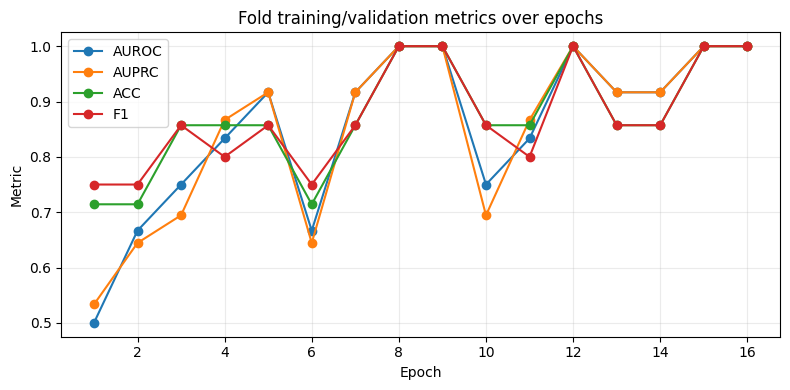

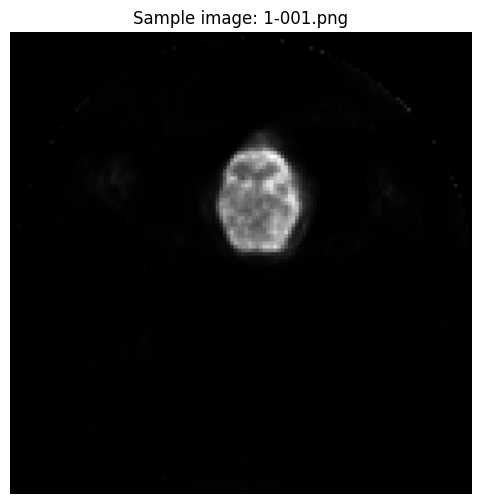

In [3]:
from PIL import Image
import numpy as np
import glob
import pandas as _pd
import pandas as _pd

# Plot best-fold metrics and history, plus show one sample CT/slide image
import matplotlib.pyplot as plt

# 1) Load aggregated CV summary if available
agg_path = OUT_DIR / 'cv_summary_all_seeds.csv'
if not agg_path.exists():
    # fallback: try to concat per-seed summaries
    seed_files = sorted([p for p in OUT_DIR.glob("cv_summary_seed*.csv")])
    if seed_files:
        df_list = [_pd.read_csv(p) for p in seed_files]
        df_summary = _pd.concat(df_list, ignore_index=True)
    else:
        df_summary = None
else:
    df_summary = _pd.read_csv(agg_path)

if df_summary is None or df_summary.empty:
    print("No CV summary found under OUT_DIR. Looking for fold history files instead...")
    # search fold dirs with history.csv and pick the fold with highest max AUROC in history
    histories = []
    for d in OUT_DIR.iterdir():
        if d.is_dir():
            hist_file = d / 'history.csv'
            if hist_file.exists():
                try:
                    h = _pd.read_csv(hist_file)
                    # take best AUROC observed in history
                    histories.append((d, h, h['AUROC'].max() if 'AUROC' in h.columns else -1.0))
                except Exception:
                    pass
    if not histories:
        print("No history.csv files found. Cannot plot metrics.")
        df_summary = None
    else:
        # pick best history folder
        best_dir, best_hist, _ = max(histories, key=lambda x: x[2])
        best_metrics_row = {
            'AUROC': float(best_hist['AUROC'].max()) if 'AUROC' in best_hist.columns else np.nan,
            'AUPRC': float(best_hist['AUPRC'].max()) if 'AUPRC' in best_hist.columns else np.nan,
            'ACC': float(best_hist['ACC'].max()) if 'ACC' in best_hist.columns else np.nan,
            'F1': float(best_hist['F1'].max()) if 'F1' in best_hist.columns else np.nan,
            'fold_dir': str(best_dir)
        }
        # Plot history and bar metric below
        hist_df = best_hist
        summary_row = best_metrics_row
else:
    # pick best row by AUROC
    best_idx = df_summary['AUROC'].idxmax()
    best_row = df_summary.loc[best_idx]
    seed = int(best_row.get('seed', 0))
    rep  = int(best_row.get('rep', 0))
    fold = int(best_row.get('fold', 0))
    fold_dir = OUT_DIR / f"seed{seed}_rep{rep}_fold{fold}"
    hist_file = fold_dir / 'history.csv'
    if hist_file.exists():
        hist_df = _pd.read_csv(hist_file)
    else:
        hist_df = None
    summary_row = {
        'AUROC': float(best_row.get('AUROC', np.nan)),
        'AUPRC': float(best_row.get('AUPRC', np.nan)),
        'ACC': float(best_row.get('ACC', np.nan)),
        'F1': float(best_row.get('F1', np.nan)),
        'fold_dir': str(fold_dir)
    }

# 2) Plot history (AUROC,AUPRC,ACC,F1 per epoch) if available
if 'hist_df' in locals() and hist_df is not None and not hist_df.empty:
    plt.figure(figsize=(8,4))
    for col in ['AUROC','AUPRC','ACC','F1']:
        if col in hist_df.columns:
            plt.plot(hist_df['epoch'], hist_df[col], marker='o', label=col)
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.title('Fold training/validation metrics over epochs')
    plt.legend()
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()
else:
    print("No history dataframe available to plot epoch-wise metrics.")



# 4) Show one sample CT/slide image (first available patient image)
sample_img_path = None
# try prefer a patient from df_match if exists
if 'df_match' in globals() and not df_match.empty:
    for pid in df_match['patient_id'].tolist():
        if pid in patient_images and patient_images[pid]:
            sample_img_path = patient_images[pid][0]
            break
# fallback to any image from patient_images
if sample_img_path is None:
    for pid, lst in patient_images.items():
        if lst:
            sample_img_path = lst[0]; break

if sample_img_path is None:
    # try to find any image file under IMAGE_ROOT
    files = list(Path(IMAGE_ROOT).rglob("*"))
    for f in files:
        if f.suffix.lower() in IMG_EXTS:
            sample_img_path = f; break

if sample_img_path is None:
    print("No image found to display.")
else:
    try:
        img = Image.open(sample_img_path).convert('RGB')
        # display with matplotlib (resize for viewing)
        plt.figure(figsize=(6,6))
        plt.imshow(np.asarray(img))
        plt.axis('off')
        plt.title(f"Sample image: {Path(sample_img_path).name}")
        plt.show()
    except Exception as e:
        print("Failed to open/display image:", e)


Cross-folds (mean ± std):
  AUROC: 0.8400 ± 0.1326
  AUPRC: 0.8675 ± 0.1033
  ACC: 0.8881 ± 0.0649
  F1: 0.8692 ± 0.0825

Using fold dir for QC: D:\research\Thesis_data\TCGA-LUAD\seed42_rep0_fold1


C:\Users\HP\AppData\Local\Temp\ipykernel_10908\4183849445.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.96])


Saved QC image: D:\research\Thesis_data\TCGA-LUAD\seed42_rep0_fold1\qc\TCGA386178_att_qc.png


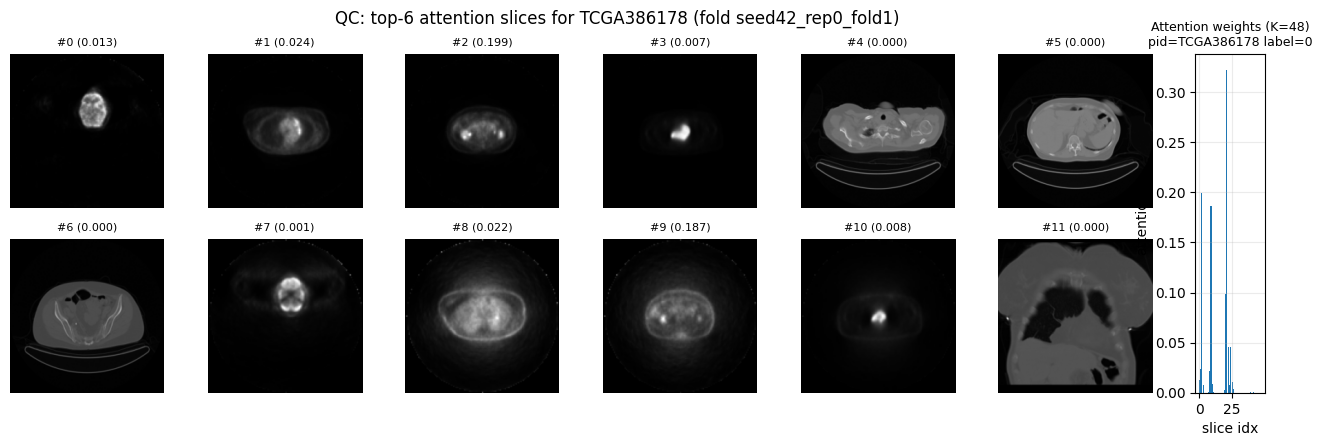

C:\Users\HP\AppData\Local\Temp\ipykernel_10908\4183849445.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.96])


Saved QC image: D:\research\Thesis_data\TCGA-LUAD\seed42_rep0_fold1\qc\TCGA505045_att_qc.png


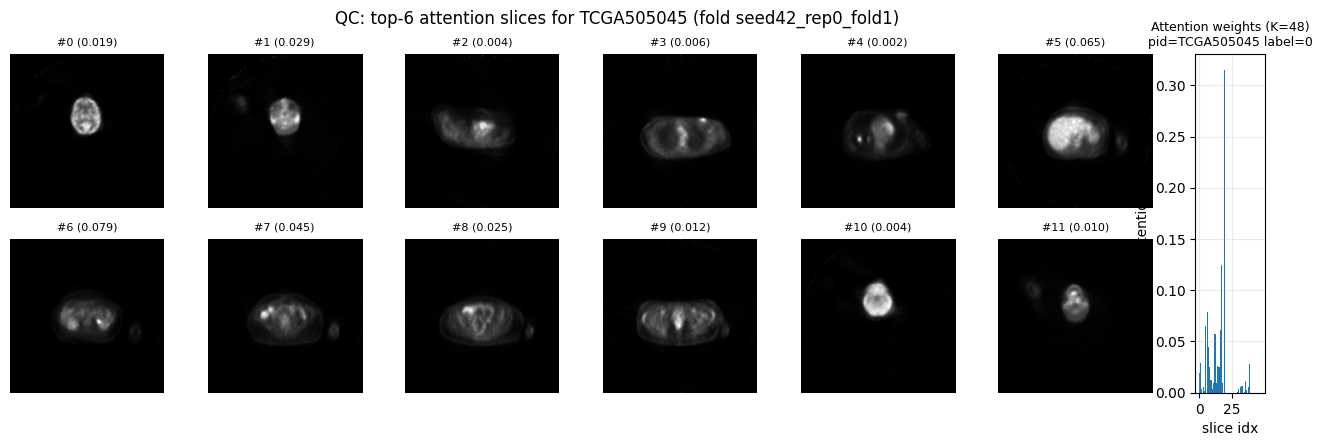

C:\Users\HP\AppData\Local\Temp\ipykernel_10908\4183849445.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.96])


Saved QC image: D:\research\Thesis_data\TCGA-LUAD\seed42_rep0_fold1\qc\TCGA506594_att_qc.png


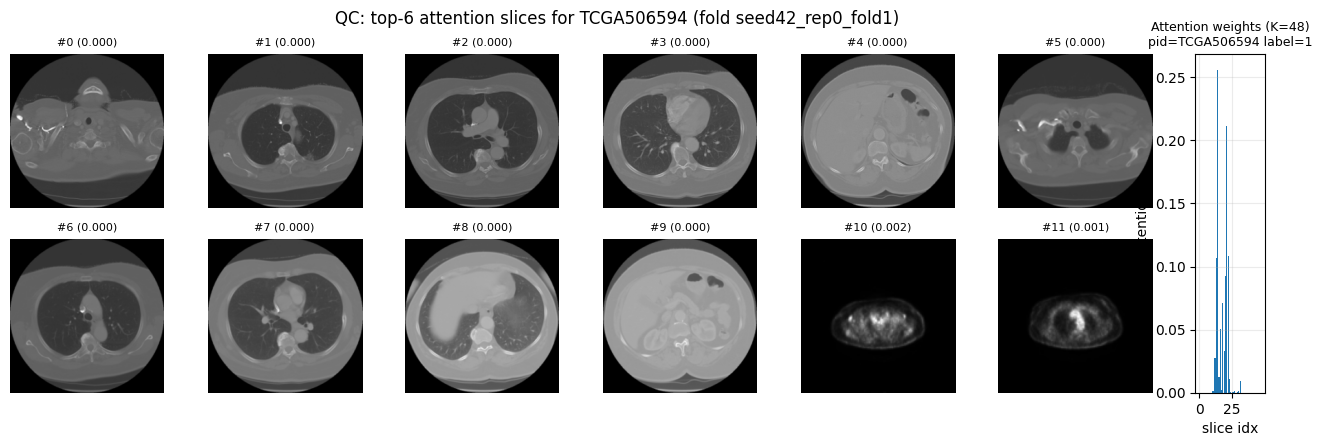

C:\Users\HP\AppData\Local\Temp\ipykernel_10908\4183849445.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.96])


Saved QC image: D:\research\Thesis_data\TCGA-LUAD\seed42_rep0_fold1\qc\TCGA505066_att_qc.png


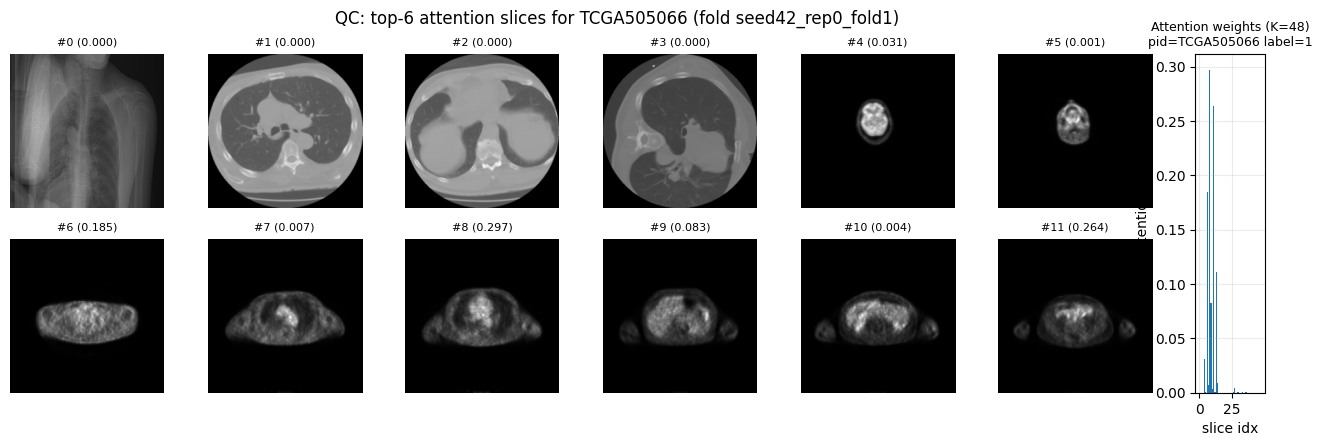

In [14]:
from pathlib import Path
import numpy as np
import torch

# QC: print report mean±std and plot attention / QC grids for top slices per patient (cell 5)
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1) Compute and print mean ± std for key metrics (prefer df_folds -> df_summary)
metrics = ["AUROC", "AUPRC", "ACC", "F1"]
def print_mean_std(df, name=""):
    ms = df[metrics].agg(['mean','std']).transpose()
    print(f"\n{name} (mean ± std):")
    for m in metrics:
        if m in df.columns:
            mu = ms.loc[m, 'mean']; sd = ms.loc[m, 'std']
            print(f"  {m}: {mu:.4f} ± {sd:.4f}")
        else:
            print(f"  {m}: N/A")

if 'df_folds' in globals() and isinstance(df_folds, (type(pd.DataFrame()),)) and not df_folds.empty:
    print_mean_std(df_folds, name="Cross-folds")
elif 'df_summary' in globals() and df_summary is not None and not df_summary.empty:
    print_mean_std(df_summary, name="Summary")
else:
    print("No fold/summary dataframe found to compute mean±std.")

# 2) Locate best fold directory to load best.pt (use summary_row / best AUROC from df_folds / scan)
best_fold_dir = None
if 'summary_row' in globals() and isinstance(summary_row, dict) and summary_row.get('fold_dir'):
    best_fold_dir = Path(summary_row['fold_dir'])
elif 'df_folds' in globals() and not df_folds.empty:
    try:
        idx = df_folds['AUROC'].idxmax()
        best_fold_dir = Path(df_folds.loc[idx, 'fold_dir'])
    except Exception:
        best_fold_dir = None

if best_fold_dir is None or not best_fold_dir.exists():
    # fallback: find any folder with best.pt
    cand = [p for p in OUT_DIR.iterdir() if p.is_dir() and (p / "best.pt").exists()]
    best_fold_dir = cand[0] if cand else None

if best_fold_dir is None:
    print("No best.pt found under OUT_DIR; skipping attention/QC plotting.")
else:
    print(f"\nUsing fold dir for QC: {best_fold_dir}")

    # attempt to load best state
    try:
        best_st = torch.load(best_fold_dir / "best.pt", map_location="cpu")
    except Exception as e:
        best_st = None
        print("Failed to load best.pt:", e)

    if best_st is None or 'model' not in (best_st or {}):
        print("best.pt missing model state; skipping model-based attention QC.")
    else:
        # instantiate model using known globals (FusionModel, BACKBONE, PRETRAINED, DROPOUT)
        rna_cols_from_state = best_st.get('rna_cols', None)
        if rna_cols_from_state is None:
            # fallback to val_df_proc columns if available
            if 'val_df_proc' in globals():
                rna_cols_from_state = [c for c in val_df_proc.columns if c not in ('patient_id','label')]
            else:
                rna_cols_from_state = []
        rna_dim = len(rna_cols_from_state)

        model = FusionModel(rna_dim=rna_dim, backbone_name=BACKBONE, pretrained=PRETRAINED, dropout=DROPOUT)
        try:
            model.load_state_dict(best_st['model'])
        except Exception as e:
            # try strict=False
            model.load_state_dict(best_st['model'], strict=False)
            print("Loaded model state with strict=False due to:", e)
        model.to(device).eval()

        # 3) Pick sample patients from validation set
        sample_pids = []
        if 'val_patients' in globals() and val_patients:
            sample_pids = val_patients[:4]  # first up to 4 patients
        elif 'df_match' in globals() and not df_match.empty:
            sample_pids = df_match['patient_id'].unique()[:4].tolist()
        else:
            # fallback to any patient_images entry
            for pid, lst in patient_images.items():
                if lst:
                    sample_pids.append(pid)
                if len(sample_pids) >= 4: break

        if not sample_pids:
            print("No sample patients found for QC plotting.")
        else:
            out_qc_dir = Path(best_fold_dir) / "qc"
            out_qc_dir.mkdir(parents=True, exist_ok=True)

            topk = 6   # how many top-attended slices to highlight
            max_cols = 6

            for pid in sample_pids:
                # find index in val_ds (if val_ds exists)
                idx = None
                if 'val_patients' in globals() and pid in val_patients:
                    idx = val_patients.index(pid)
                elif 'val_df_proc' in globals():
                    try:
                        idx = val_df_proc.index[val_df_proc['patient_id'] == pid].tolist()
                        idx = idx[0] if idx else None
                    except Exception:
                        idx = None

                if idx is None:
                    print(f"Patient {pid}: not found in validation list; skipping.")
                    continue

                try:
                    sample = val_ds[idx]
                except Exception as e:
                    print(f"Failed to fetch dataset item for {pid} at idx={idx}: {e}")
                    continue

                bag = sample['bag']            # tensor [K,C,H,W]
                rna = sample['rna']            # tensor [D]
                # ensure contiguous tensors so any .view() inside the model won't fail
                if isinstance(bag, torch.Tensor) and not bag.is_contiguous():
                    bag = bag.contiguous()
                if isinstance(rna, torch.Tensor) and not rna.is_contiguous():
                    rna = rna.contiguous()
                label = int(sample['label'].item()) if isinstance(sample['label'], torch.Tensor) else int(sample['label'])

                with torch.no_grad():
                    # model expects either [K,C,H,W] or batch [1,K,C,H,W]
                    logit, att_w = model(bag.to(device), rna.to(device))
                    # att_w: [K] or [1,K]
                    aw = att_w.detach().cpu().numpy()
                    if aw.ndim == 2 and aw.shape[0] == 1:
                        aw = aw[0]
                    # normalize for plotting
                    aw = aw / (aw.sum() + 1e-12)

                K = bag.shape[0]
                n_display = min(K, 12)
                cols = min(max_cols, n_display)
                rows = int(np.ceil(n_display / cols))

                fig = plt.figure(figsize=(cols*2.2+3, rows*2.2))
                gs = fig.add_gridspec(rows, cols + 1, width_ratios=[1.0]*cols + [0.45], wspace=0.3)

                # convert images to numpy for plotting
                imgs_np = []
                for i in range(n_display):
                    t = bag[i].cpu().permute(1,2,0).numpy()  # H,W,C in 0..1
                    t = np.clip(t, 0.0, 1.0)
                    imgs_np.append(t)

                # highlight topk indices
                topk_idx = np.argsort(-aw)[:topk]

                for i in range(n_display):
                    r = i // cols; c = i % cols
                    ax = fig.add_subplot(gs[r, c])
                    ax.imshow(imgs_np[i])
                    ax.axis('off')
                    title = f"#{i} ({aw[i]:.3f})" if i < len(aw) else f"#{i}"
                    ax.set_title(title, fontsize=8)
                    if i in topk_idx:
                        for spine in ax.spines.values():
                            spine.set_edgecolor('red'); spine.set_linewidth(2.5)

                # attention bar plot on right
                axb = fig.add_subplot(gs[:, cols])
                axb.bar(np.arange(len(aw)), aw, color='C0')
                axb.set_title(f"Attention weights (K={K})\npid={pid} label={label}", fontsize=9)
                axb.set_xlabel("slice idx")
                axb.set_ylabel("attention")
                axb.grid(alpha=0.25)

                plt.suptitle(f"QC: top-{topk} attention slices for {pid} (fold {best_fold_dir.name})", fontsize=12)
                plt.tight_layout(rect=[0,0,1,0.96])

                out_path = out_qc_dir / f"{pid}_att_qc.png"
                try:
                    fig.savefig(out_path, dpi=150)
                    print(f"Saved QC image: {out_path}")
                except Exception as e:
                    print("Failed to save QC image:", e)
                plt.show()
                plt.close(fig)